## Does the inclusion of cryptocurrency-based indicies extend the MV frontier of a well diversified equity investor?

In [1]:
import numpy as np
import pandas as pd
import scipy 
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Paramaters
rf = 0.001 # Risk-free rate 
periods_per_year = 260 # Number of trading days per year


To use own data --> requires one CSV with returns for benchmark. 
* One CSV with returns for additional returns that one would consider adding into the portfolio
* First column in both of these files need to be the date column

Importing benchmark & crypto portfolio created in data_grabbing.ipynb, creating the list of names of industry portfolios and names of cryptocurrency pairs to be put inside the optimizer

In [2]:
test_industry = pd.read_csv('../data/industry_returns.csv')
test_crypto = pd.read_csv('../data/crypto_returns.csv')
crypto = test_crypto.columns.values.tolist()[1:]

# Defining lists used later:
industry = test_industry.columns.values.tolist()[1:]
industry_and_crypto = industry + crypto

print(industry)
print(industry_and_crypto)

['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other']
['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other', 'BTC-USD', 'ETH-USD', 'XRP-USD']


Double check on dates of available data (excluding the weekend price data characteristic of cryptocurrency pairs)

In [3]:
# Convert the indices to sets
dates_in_industry = set(test_industry.index)
dates_in_crypto = set(test_crypto.index)

# Find dates that are only in crypto_returns
dates_only_in_crypto_returns = dates_in_crypto - dates_in_industry

# Convert to a sorted list for easier viewing or further processing
dates_only_in_crypto_returns = sorted(list(dates_only_in_crypto_returns))

# Print or inspect the dates
print(dates_only_in_crypto_returns)

[]


Creating the main dataframe consisting of all columns of ordinary returns from both .csv files joined based on the respective dates

In [4]:
ind_crypto = pd.merge(test_industry, test_crypto, on='Date') # this is an inner join --> only includes values that has dates in both df:s
ind_crypto = ind_crypto.set_index('Date')
ind_crypto

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,BTC-USD,ETH-USD,XRP-USD
Date,,,,,,,,,,,,,,,
2017-11-10,0.0109,0.0041,0.0025,-0.0041,-0.0010,0.0034,-0.0029,-0.0062,0.0054,0.0037,0.0001,0.0015,-0.073554,-0.067411,-0.050600
2017-11-13,0.0027,0.0053,-0.0036,-0.0082,0.0054,-0.0007,-0.0084,0.0047,-0.0028,-0.0044,0.0045,-0.0050,-0.008862,0.058355,-0.014728
2017-11-14,0.0053,-0.0027,-0.0056,-0.0335,-0.0072,-0.0007,-0.0078,0.0116,0.0016,-0.0123,0.0029,-0.0058,0.011626,0.066037,0.031375
2017-11-15,-0.0040,-0.0083,-0.0061,-0.0131,-0.0132,-0.0063,0.0018,-0.0097,-0.0012,0.0049,0.0006,-0.0053,0.102444,-0.012659,0.014922
2017-11-16,0.0199,0.0258,0.0167,0.0073,0.0142,0.0219,0.0183,0.0037,0.0214,0.0201,0.0132,0.0182,0.076023,-0.007298,0.066450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.0102,0.0035,-0.0019,0.0185,0.0066,-0.0006,-0.0102,-0.0010,-0.0011,-0.0089,0.0046,-0.0001,-0.010575,-0.003104,-0.013754
2023-09-26,-0.0039,-0.0168,-0.0131,-0.0058,-0.0116,-0.0135,-0.0178,-0.0230,-0.0125,0.0171,-0.0114,-0.0088,-0.003089,0.003207,-0.007425
2023-09-27,-0.0037,0.0021,0.0099,0.0323,-0.0050,0.0074,0.0097,-0.0076,0.0070,-0.0007,-0.0012,0.0027,0.005167,0.002557,-0.004208


### Defining functions needed to compute the efficient frontier:

In [5]:
#we should probably move these 3 functions to a separate .py file so we can call upon them when necessary

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = opt.minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [6]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

Computing the sharpe ratios of all chosen instruments (which are merged inside of the ind_crypto dataframe)

In [7]:
# Load the processed data for analysis, choose the RF rate
industry_SR = sharpe_ratio(ind_crypto, rf, periods_per_year).sort_values()
industry_SR

Telcm     -0.019576
Hlth       0.035539
XRP-USD    0.129253
Enrgy      0.217357
Durbl      0.223441
NoDur      0.226161
Money      0.310830
Utils      0.315226
Chems      0.353182
ETH-USD    0.353743
BTC-USD    0.356315
Other      0.396179
Manuf      0.399403
Shops      0.448222
BusEq      0.479068
dtype: float64

Computing efficient froniters

In [8]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies')
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies')
    
    ax.set_xlim(left=0.0114, right=0.016)
    ax.set_ylim(bottom=0.0, top=0.12)

    # Customize the plot as needed
    plt.title("Efficient Frontier Comparison")
    plt.xlabel("Volatility")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    
    plt.savefig("../reports/figures/figure1.png")
    plt.show()
    

In [9]:
er = annualize_rets(ind_crypto, periods_per_year)
cov = ind_crypto.cov()

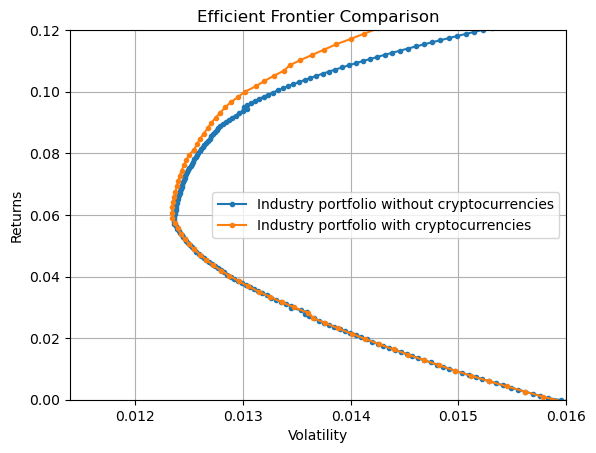

In [10]:
industry_crypto_combined_plots = plot_ef(200, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto]) 
#maybe use matplotlib here? It makes more sense to calculate all values then plot it? 
